In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Data Preparation
### Seeding the Data for reproducibilty

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# Device configuration: use CUDA if available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data Augmentation for Training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Data Transformation for Testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Split the training set into sub-training and validation sets (70-30 split) without random shuffling
train_size = int(0.7 * len(trainset))
val_size = len(trainset) - train_size
indices = list(range(len(trainset)))
train_indices = indices[:train_size]
val_indices = indices[train_size:]
sub_trainset = Subset(trainset, train_indices)
valset = Subset(trainset, val_indices)

# Create a generator with the fixed seed
g = torch.Generator()
g.manual_seed(seed)

# Create DataLoaders with shuffling and reproducibility
full_data_loader = DataLoader(trainset,batch_size=64, shuffle=True, generator=g)
trainloader = DataLoader(sub_trainset, batch_size=64, shuffle=True, generator=g)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Using device: cuda


100%|██████████| 169001437/169001437 [00:04<00:00, 40742694.95it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


### printing the images to verify if same images are being loaded everytime

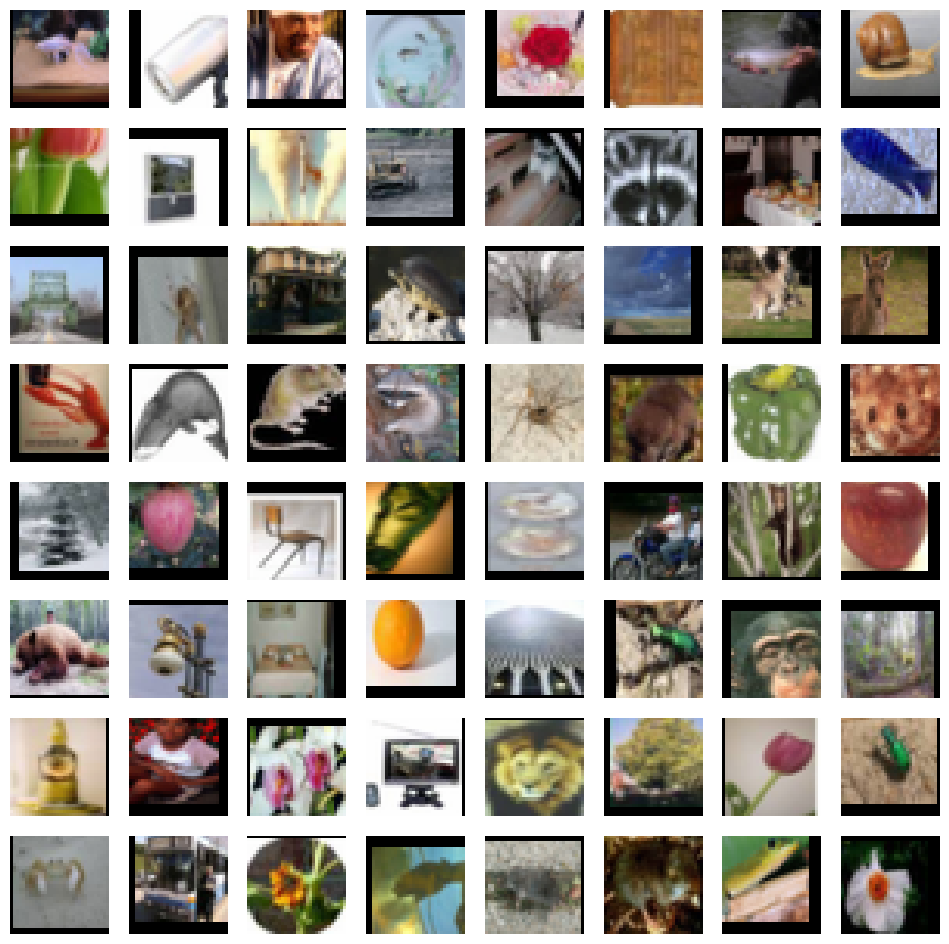

In [3]:
def show_batch(loader):
    # Get a batch of training data
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Unnormalize the images
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    images = images.numpy().transpose((0, 2, 3, 1))
    images = std * images + mean
    images = np.clip(images, 0, 1)

    # Plot the images in the batch
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Show a batch of training images
show_batch(trainloader)

## Functions to Train model with validation data, Train model with complete data, and Compute metrics

In [4]:
# Training function
def train_model(model, criterion, optimizer, num_epochs):
    losses = []
    validation_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')
        losses.append(running_loss/len(trainloader))

        # Validation phase
        model.eval()  # Set model to evaluation mode
        total = correct = 0
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Validation Accuracy: {100 * correct / total}%')
        validation_accuracies.append(100 * correct / total)
    return losses,validation_accuracies

# Training function for the full training set
def full_train_model(model, optimizer, criterion, num_epochs):
    losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in full_data_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        # Print loss statistics per epoch
        epoch_loss = running_loss / len(full_data_loader.dataset)
        losses.append(epoch_loss)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    return losses

# Function to calculate metrics

def calculate_metrics(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predicted, average='weighted')
    return accuracy, f1

## Model 1, ResNet Inspired model

In [5]:
#Residual Blocks definition
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        return F.relu(out)
#class of ResNet Model
class ResNetForCIFAR(nn.Module):
    def __init__(self, block, layers, num_classes=100):
        super(ResNetForCIFAR, self).__init__()
        self.in_channels = 64
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



## Model 2, GoogleNet Inspired Model

In [6]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, reduce3x3, out3x3, reduce5x5, out5x5, pool_proj):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out1x1, kernel_size=1),
            nn.BatchNorm2d(out1x1),
            nn.ReLU(inplace=True),
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, reduce3x3, kernel_size=1),
            nn.BatchNorm2d(reduce3x3),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduce3x3, out3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out3x3),
            nn.ReLU(inplace=True),
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, reduce5x5, kernel_size=1),
            nn.BatchNorm2d(reduce5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduce5x5, out5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out5x5),
            nn.ReLU(inplace=True),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        branch1x = self.branch1(x)
        branch2x = self.branch2(x)
        branch3x = self.branch3(x)
        branch4x = self.branch4(x)
        outputs = torch.cat([branch1x, branch2x, branch3x, branch4x], 1)
        return outputs

class ImprovedGoogLeNet(nn.Module):
    def __init__(self, num_classes=100):
        super(ImprovedGoogLeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True)
        )
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception modules
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception4a = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception5a = InceptionModule(480, 192, 96, 208, 16, 48, 64)

        # Adaptive average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)  # Assuming the output dimension of inception5a is 512

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)

        x = self.avgpool(x)  # Reduces to [batch_size, 512, 1, 1]
        x = torch.flatten(x, 1)  # Flatten the tensor to [batch_size, 512]
        x = self.dropout(x)
        x = self.fc(x)

        return x

## Model 3 - AlexNet Inspired Model

In [7]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 100)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Training ResNet Model with optimal Parameters

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ResNet = ResNetForCIFAR(ResidualBlock, [2, 2, 2, 2], num_classes=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ResNet.parameters(), lr=0.001,betas=(0.9,0.99))
num_epochs = 30
losses_ResNet_full= full_train_model(model_ResNet,optimizer,criterion, num_epochs)

Epoch 1, Loss: 3.8112219358825685
Epoch 2, Loss: 3.0239401538848876
Epoch 3, Loss: 2.4702927241516113
Epoch 4, Loss: 2.119350665893555
Epoch 5, Loss: 1.861672452507019
Epoch 6, Loss: 1.6608359826660157
Epoch 7, Loss: 1.4974648358154297
Epoch 8, Loss: 1.3626094295883178
Epoch 9, Loss: 1.2447975873947144
Epoch 10, Loss: 1.1355335868644714
Epoch 11, Loss: 1.0417380945205688
Epoch 12, Loss: 0.9612547235107421
Epoch 13, Loss: 0.874946370010376
Epoch 14, Loss: 0.7975242918014527
Epoch 15, Loss: 0.7238437841033936
Epoch 16, Loss: 0.6601060951423645
Epoch 17, Loss: 0.5996504697990418
Epoch 18, Loss: 0.5476520844841003
Epoch 19, Loss: 0.49656317556381224
Epoch 20, Loss: 0.4483191439819336
Epoch 21, Loss: 0.4112952194595337
Epoch 22, Loss: 0.36857243616104124
Epoch 23, Loss: 0.34847395290374755
Epoch 24, Loss: 0.3152384839105606
Epoch 25, Loss: 0.29185092334747315
Epoch 26, Loss: 0.263765755238533
Epoch 27, Loss: 0.2514818208169937
Epoch 28, Loss: 0.2352087973165512
Epoch 29, Loss: 0.22318988785

## Training GoogleNet Model with optimal Parameters

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_G = ImprovedGoogLeNet(num_classes=100).to(device)
num_epochs = 36
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_G.parameters(), lr=0.001,betas = (0.9,0.999), weight_decay=0.0)

# Assuming trainloader and validationloader are already defined
losses_googleNet_full= full_train_model(model_G,optimizer,criterion, num_epochs)

Epoch 1, Loss: 3.719478991165161
Epoch 2, Loss: 3.1086633170318603
Epoch 3, Loss: 2.81935442489624
Epoch 4, Loss: 2.626227197418213
Epoch 5, Loss: 2.4829345429229734
Epoch 6, Loss: 2.3681456244659422
Epoch 7, Loss: 2.2764987840271
Epoch 8, Loss: 2.185633573913574
Epoch 9, Loss: 2.1207582543182375
Epoch 10, Loss: 2.053993467330933
Epoch 11, Loss: 1.9997285636901856
Epoch 12, Loss: 1.9489563638305665
Epoch 13, Loss: 1.8985467446136475
Epoch 14, Loss: 1.8582600827789306
Epoch 15, Loss: 1.8082359880828858
Epoch 16, Loss: 1.7786634565734862
Epoch 17, Loss: 1.7478676208496093
Epoch 18, Loss: 1.7149916474151612
Epoch 19, Loss: 1.6777432022857666
Epoch 20, Loss: 1.6488135945892335
Epoch 21, Loss: 1.6100243128204346
Epoch 22, Loss: 1.586035943069458
Epoch 23, Loss: 1.5726274363327026
Epoch 24, Loss: 1.5313812127685547
Epoch 25, Loss: 1.516900798149109
Epoch 26, Loss: 1.4931842443847656
Epoch 27, Loss: 1.4663568926239015
Epoch 28, Loss: 1.4572191256713867
Epoch 29, Loss: 1.423778705253601
Epoch 

## Training AlexNet Model with optimal Parameters

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
num_epochs = 35
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001,weight_decay=1e-4, alpha = 0.9)
losses_AlexNet_full = full_train_model(model,optimizer,criterion, num_epochs)

Epoch 1, Loss: 4.620399219818116
Epoch 2, Loss: 3.5719845928192138
Epoch 3, Loss: 3.201842196121216
Epoch 4, Loss: 2.915836371688843
Epoch 5, Loss: 2.7011151791381836
Epoch 6, Loss: 2.5587843604278566
Epoch 7, Loss: 2.482055168533325
Epoch 8, Loss: 2.3926443265533446
Epoch 9, Loss: 2.3420175141143798
Epoch 10, Loss: 2.295466361312866
Epoch 11, Loss: 2.246027308349609
Epoch 12, Loss: 2.223904470062256
Epoch 13, Loss: 2.201667042160034
Epoch 14, Loss: 2.1821764447021486
Epoch 15, Loss: 2.154292956161499
Epoch 16, Loss: 2.146350094604492
Epoch 17, Loss: 2.145370097732544
Epoch 18, Loss: 2.1427927697753906
Epoch 19, Loss: 2.1570456368255617
Epoch 20, Loss: 2.1017008654022216
Epoch 21, Loss: 2.0989500102615355
Epoch 22, Loss: 2.089122367401123
Epoch 23, Loss: 2.169376275177002
Epoch 24, Loss: 2.069613077507019
Epoch 25, Loss: 2.06792515914917
Epoch 26, Loss: 2.1358036991882323
Epoch 27, Loss: 2.0453445072174072
Epoch 28, Loss: 2.091240695762634
Epoch 29, Loss: 2.0477047077178954
Epoch 30, L

## Plotting the losses vs Epochs

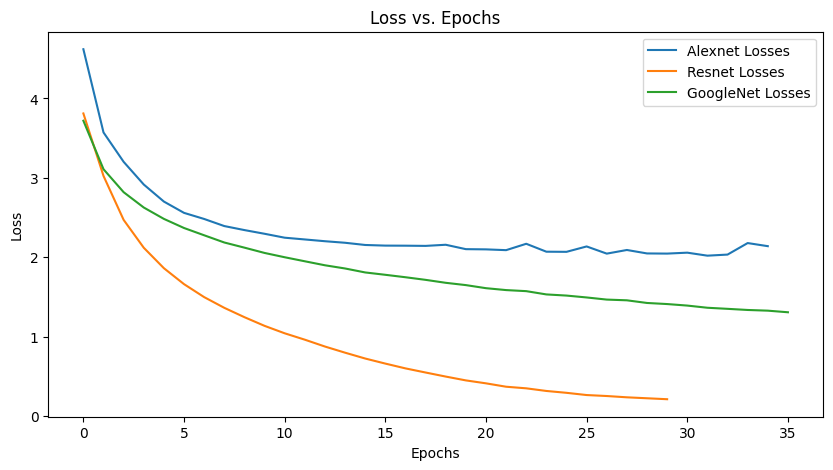

In [13]:
#plt.plot(losses_AlexNet_full)
plt.figure(figsize=(10, 5))
plt.plot(losses_AlexNet_full, label='Alexnet Losses')
plt.plot(losses_ResNet_full, label='Resnet Losses')
plt.plot(losses_googleNet_full, label='GoogleNet Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

## Recording the test results

In [14]:
res_test_accuracy,res_f1 = calculate_metrics(model_ResNet, testloader, device)

goog_test_accuracy,goog_f1= calculate_metrics(model_G, testloader, device)

alex_test_accuracy,goog_alex_f1 = calculate_metrics(model, testloader, device)


### Plotting the Models and accuracies

ResNet Test Accuracy: 66.38
GoogleNet Test Accuracy: 55.52
AlexNet Test Accuracy: 53.24


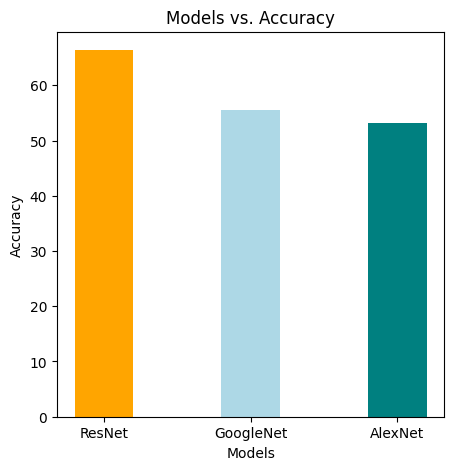

In [32]:
models = ['ResNet', 'GoogleNet', 'AlexNet']
accuracies = [res_test_accuracy, goog_test_accuracy, alex_test_accuracy]

# Print accuracy and scores
for model, accuracy in zip(models, accuracies):
    print(f"{model} Test Accuracy: {accuracy}")

plt.figure(figsize=(5, 5))
plt.bar(models, accuracies, width=0.4, color=['orange', 'lightblue', 'teal'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Models vs. Accuracy')

plt.show()

### Plotting the Models and F1 Scores

ResNet f1_score: 0.6643307364589229
GoogleNet f1_score: 0.5531897637154458
AlexNet f1_score: 0.5347125676816797


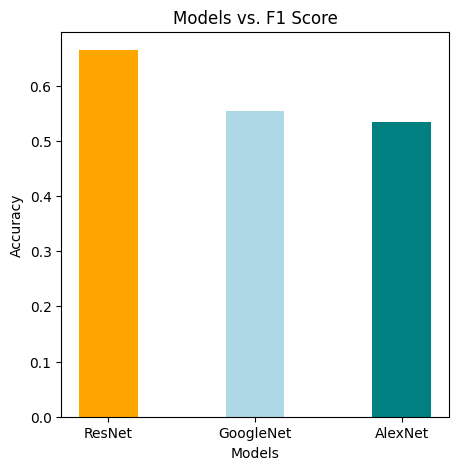

In [33]:
models = ['ResNet', 'GoogleNet', 'AlexNet']
f1_scores = [res_f1, goog_f1, goog_alex_f1]

# Print accuracy and scores
for model, f1_score in zip(models, f1_scores):
    print(f"{model} f1_score: {f1_score}")

plt.figure(figsize=(5, 5))
plt.bar(models, f1_scores, width=0.4, color=['orange', 'lightblue', 'teal'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Models vs. F1 Score')

plt.show()